# Notebook to show the Glacier model differences 

In [8]:
# # these code lines above are equal to those at the beginning of 2_glacier_vs_climate_change


# download it here https://cluster.klima.uni-bremen.de/~lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc
# and change the path to your local path
DATE = 'Jun29' #'apr04' (has OGGM runaway effect of glaciers inside)
fill_option = 'repeat_last_20yrs'

import xarray as xr
import numpy as np
import pandas as pd
import scipy
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
# for plots withinplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


#ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)

try:
    path_merged_runs_scaled = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    path_merged_runs_scaled_extend = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)

except:
    path_merged_runs_scaled = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    path_merged_runs_scaled_extend = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)
    
# --> comes from isimip3b_postprocessing_analysis/isimip3b_postprocess_to_monthly.ipynb
pd_global_temp_exp = pd.read_csv('../data/temp_ch_ipcc_isimip3b.csv', index_col = 0)


from help_func import pal_models, model_order, d_reg_num_name, model_order_anonymous
# remove OGGM_v153 and Huss
hue_order_anonymous = []
hue_order = model_order[:-2] 
glac_models = hue_order 
pal_models = pal_models[:-2]
pal_models = sns.color_palette(pal_models)
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])

print(hue_order, hue_order_anonymous)
pal_models

# test without Zeokllari and OGGM-VAS
sel = False
if sel:
    glac_models = ['James', 'Rounce', 'Compagno', 'Kraaijenbrink', 'GLIMB', 'OGGM_v16'] #, 'OGGM-VAS', 'Zekollari'] # OGGM_v153, Huss
    ds_reg_models = ds_reg_models.sel(model_author=glac_models)
    ds_reg_models_vol = ds_reg_models.volume_m3.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']

    # Let's take the median estimate from all glacier models for every RGI region and then do the sum:
else:    
    ds_reg_models = ds_reg_models.sel(model_author=glac_models)
    ds_reg_models_vol = ds_reg_models.volume_m3 #.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']

# Let's take the median estimate from all glacier models for every RGI region and then do the sum:
ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])
ds_reg_models_med_vol = ds_reg_models_vol.median(dim='model_author')
num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 



def get_glob_temp_exp(region='global'):
    pd_global_temp_exp_glac = pd.read_csv('../data/temp_ch_ipcc_isimip3b_glacier_regionally.csv', index_col = 0)
    _p = pd_global_temp_exp_glac.loc[pd_global_temp_exp_glac.region == region]
    _p = _p.groupby(['gcm','period_scenario']).mean()
    return _p
np.testing.assert_allclose(get_glob_temp_exp(region='global')['temp_ch_ipcc'].values,
                                  pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()['temp_ch_ipcc'].values, rtol=1e-5)
import matplotlib
matplotlib.__version__
pd_global_temp_exp_m = get_glob_temp_exp(region='global')


['Rounce', 'Compagno', 'Zekollari', 'OGGM_v16', 'OGGM-VAS', 'GLIMB', 'Kraaijenbrink', 'James', 'CISM2'] ['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6', 'model 7', 'model 8', 'model 9']


----

- todo: maybe use regional glacier stuff instead for the "classes" ???

In [9]:
ds_reg_models_med_vol = ds_reg_models_med_vol.assign_coords(temp_ch_ipcc= ('experiments',
                                                                      pd_global_temp_exp_m.loc[ds_reg_models_med_vol.experiments, # make sure thatwe use the same experiments
                                                                                             'temp_ch_ipcc']))
# need that to have bot volume_m3 and temp_ch_ipcc as variables
ds_reg_models_med_vol = ds_reg_models_med_vol.reset_coords()

ds_reg_models_vol = ds_reg_models_vol.assign_coords(temp_ch_ipcc = ('experiments',
                                                                      pd_global_temp_exp_m.loc[ds_reg_models_vol.experiments, # make sure thatwe use the same experiments
                                                                                             'temp_ch_ipcc']))
# need that to have bot volume_m3 and temp_ch_ipcc as variables
ds_reg_models_vol = ds_reg_models_vol.reset_coords()

In [10]:
last_yr = False
if last_yr:
    ds_reg_models_vol_5000 = ds_reg_models_vol.isel(simulation_year=-1)
    ds_reg_models_med_vol_5000 = ds_reg_models_med_vol.isel(simulation_year=-1)
else:
    ds_reg_models_vol_5000 = ds_reg_models_vol.copy()
    _vol = ds_reg_models_vol_5000.isel(simulation_year=slice(-21,-1)).volume_m3.mean(dim='simulation_year')
    ds_reg_models_vol_5000['volume_m3'] = _vol
    ds_reg_models_vol_5000 = ds_reg_models_vol_5000.reset_coords()
    
    ds_reg_models_med_vol_5000 = ds_reg_models_med_vol.copy()
    _vol = ds_reg_models_med_vol_5000.isel(simulation_year=slice(-21,-1)).volume_m3.mean(dim='simulation_year')
    ds_reg_models_med_vol_5000['volume_m3'] = _vol
    ds_reg_models_med_vol_5000 = ds_reg_models_med_vol_5000.reset_coords()


## 1. in the equilibrium (5000-yr) state
- idea: 
    - compute for every of the 80 experiments and every RGI regions the relative volume differences to the median response
    - take all these differences and create boxplots with them!


In [11]:
ds_reg_models_med_vol_5000['relative volume change (in %)'] = 100*ds_reg_models_med_vol_5000.volume_m3/ds_reg_models_med_vol.isel(simulation_year=0).volume_m3
ds_reg_models_vol_5000['relative volume change (in %)'] = 100*ds_reg_models_vol_5000.volume_m3/ds_reg_models_vol.isel(simulation_year=0).volume_m3
ds_reg_models_vol_5000['delta relative volume change (in %, to median model)'] = ds_reg_models_vol_5000['relative volume change (in %)'] - ds_reg_models_med_vol_5000['relative volume change (in %)']
min_t_r, max_t_r = ds_reg_models_vol_5000['temp_ch_ipcc'].min()*1.01, ds_reg_models_vol_5000['temp_ch_ipcc'].max()*1.01

ds_reg_models_vol_5000_test = ds_reg_models_vol_5000.copy()
np.testing.assert_allclose(ds_reg_models_vol_5000_test['delta relative volume change (in %, to median model)'], ds_reg_models_vol_5000['delta relative volume change (in %, to median model)'])

In [12]:
# remove unnecessary variables to make the stacking faster... 
ds_reg_models_vol_5000 = ds_reg_models_vol_5000.drop('volume_m3')
ds_reg_models_vol_5000 = ds_reg_models_vol_5000.drop('relative volume change (in %)')

In [ ]:
ds_reg_models_vol_5000_unstack = ds_reg_models_vol_5000.unstack('experiments')
ref_period = '1995-2014_hist'
diff = ds_reg_models_vol_5000_unstack['delta relative volume change (in %, to median model)'] - ds_reg_models_vol_5000_unstack['delta relative volume change (in %, to median model)'].sel(period_scenario=ref_period)
ds_reg_models_vol_5000_unstack['delta relative volume change (in %, to median model, relative to ref period )'] = diff
ds_reg_models_vol_5000 = ds_reg_models_vol_5000_unstack.stack(experiments=['gcm','period_scenario'])

pd_reg_models_vol_5000 = ds_reg_models_vol_5000.to_dataframe()
pd_reg_models_vol_5000 = pd_reg_models_vol_5000.reset_index(drop=True).dropna()

In [ ]:
pd_reg_models_vol_5000

In [186]:
# compute amount of RGI regions per model 
pd_regional_sum_initial_models = ds_reg_models.sel(simulation_year=0).to_dataframe()
pd_regional_sum_initial_models = pd_regional_sum_initial_models.reset_index()
#pd_reg_models = pd_reg_models.dropna()
pd_reg_models_count = pd_regional_sum_initial_models.groupby(['rgi_reg', 'model_author'])['volume_m3'].count().reset_index()
pd_reg_models_count = pd_reg_models_count.rename(columns={'volume_m3':'n_experiments'})
total_count= pd_reg_models_count.groupby('model_author').sum()

labels_l = []
labels_l_anonym = []
for j,n in enumerate((total_count/80).round(0).astype(int).loc[hue_order].values.squeeze()):
    if n==1:
        label = f'{hue_order[j]} ({n} region)'
        label_a = f'{hue_order_anonymous[j]} ({n} region)' 
    else:
        label = f'{hue_order[j]} ({n} regions)'
        label_a = f'{hue_order_anonymous[j]} ({n} regions)'
    labels_l.append(label)
    labels_l_anonym.append(label_a)

### 1a: "normal" differences

In [181]:
# create "classes" of global temp. change

T0_l, T1_l = [], []
temp_labels = []
for t0, t1 in zip([min_t_r, 2, 4],[2, 4, max_t_r]):
    temp_label = f'{t0:.1f}°C-{t1:.1f}°C'
    condi = (pd_reg_models_vol_5000.temp_ch_ipcc <=t1)&(pd_reg_models_vol_5000.temp_ch_ipcc >=t0)
    pd_reg_models_vol_5000.loc[condi, 'temp_ch_classes'] = temp_label

pd_reg_models_vol_5000['temp_ch_classes']

0        -0.2°C-2.0°C
1        -0.2°C-2.0°C
2        -0.2°C-2.0°C
3        -0.2°C-2.0°C
4        -0.2°C-2.0°C
             ...     
13035     4.0°C-6.9°C
13036     4.0°C-6.9°C
13037     2.0°C-4.0°C
13038     4.0°C-6.9°C
13039     4.0°C-6.9°C
Name: temp_ch_classes, Length: 8544, dtype: object

<AxesSubplot:xlabel='model_author', ylabel='delta relative volume change (in %, to median model)'>

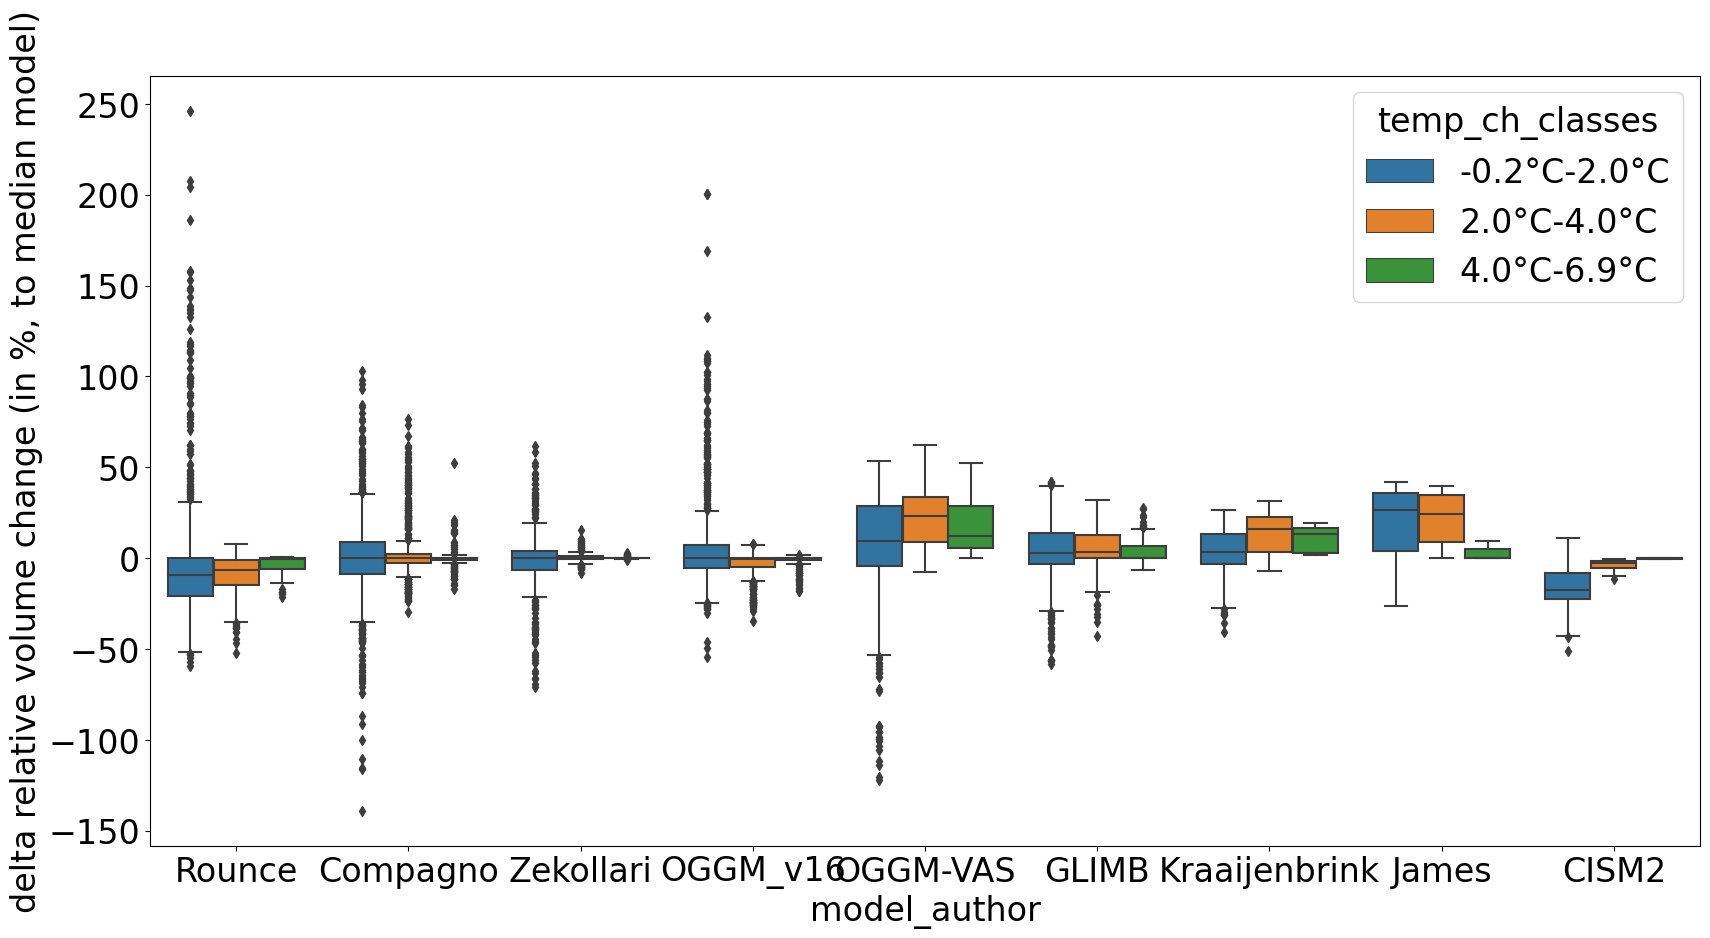

In [182]:
plt.figure(figsize=(20,10))
sns.boxplot(data=pd_reg_models_vol_5000, x='model_author', y='delta relative volume change (in %, to median model)', hue='temp_ch_classes')

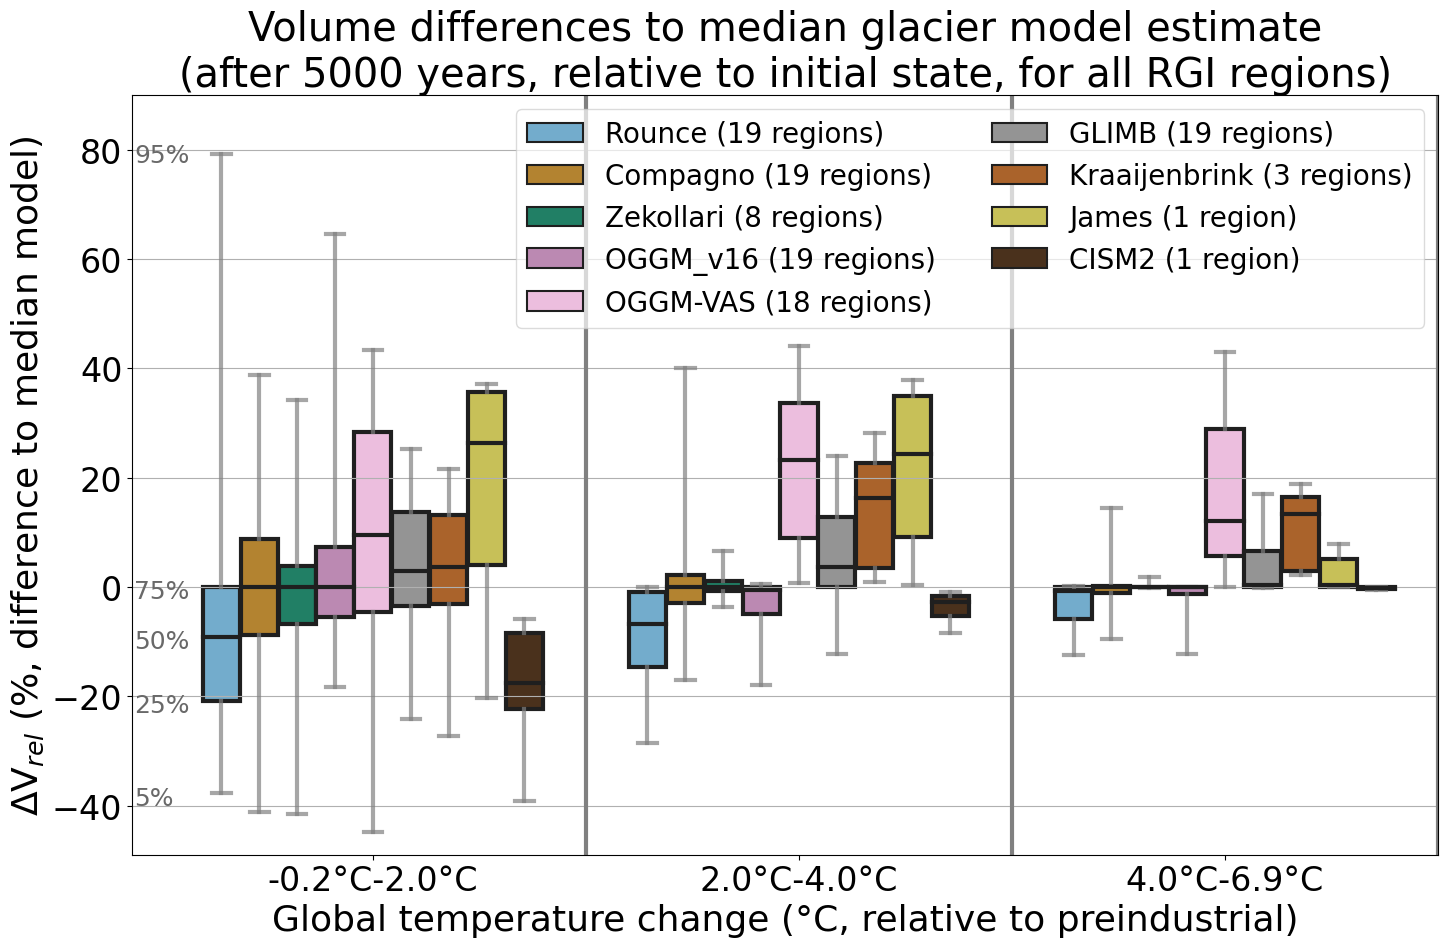

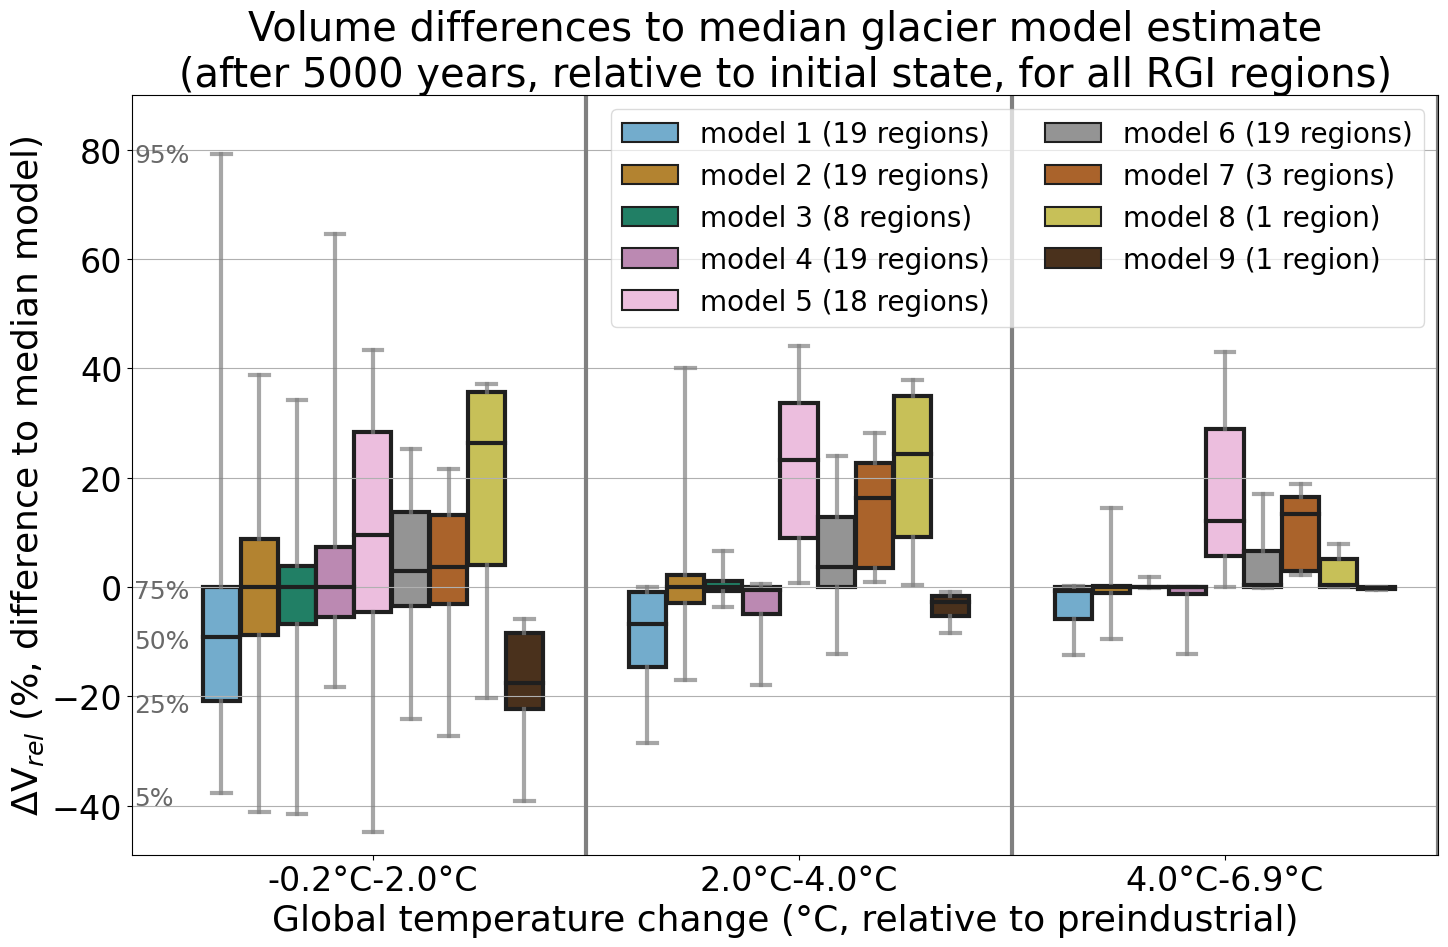

In [156]:

for anonym in ['', '_anonym']:
    plt.figure(figsize=(15,10))
    plt.rc('font', size=24)  
    sns.boxplot(data=pd_reg_models_vol_5000, hue='model_author', y='delta relative volume change (in %, to median model)',
                x='temp_ch_classes', palette=pal_models, saturation=0.6,
               hue_order=hue_order, dodge = True, #hue='ssp',
                                    fliersize=0, whis = [5,95], 
                                    #y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    capprops={'color':'grey', 'alpha':0.7},
                                    whiskerprops={'color':'grey', 'alpha':0.7},)
    plt.grid(axis='y')
    plt.title('Volume differences to median glacier model estimate\n(after 5000 years, relative to initial state, for all RGI regions)')
    plt.ylabel(r'$\Delta$V$_{rel}$ (%, difference to median model)', fontsize=26)
    plt.xlabel('Global temperature change (°C, relative to preindustrial)', fontsize=26)
    for f in np.arange(0.5,3,1):
        plt.axvline(f, color= 'grey', ls='-', lw=3)

    ax = plt.gca()
    _leg = ax.get_legend()
    handles, labels = ax.get_legend_handles_labels()
    _leg.remove()
    #n = len(hue_order)
    if anonym=='_anonym':
        leg = ax.legend(handles, labels_l_anonym, #title=f'{n} models',
                        loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
    else:
        leg = ax.legend(handles, labels_l, #title=f'{n} models',
                        loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
    plt.ylim([-49, 90])
    
    qs = pd_reg_models_vol_5000.groupby(['model_author', 'temp_ch_classes'])['delta relative volume change (in %, to median model)'].quantile([0.05,0.25,0.5,0.75,0.95]).loc[('Rounce', '-0.2°C-2.0°C')].values
    for p,q in enumerate(qs):
        perci = [5,25,50,75,95][p]
        if perci <=75:
            ax.text(-0.56,q-2,f'{perci}%', color = 'dimgrey', fontsize=18)
        else:
            ax.text(-0.56,q*0.98,f'{perci}%', color = 'dimgrey', fontsize=18)
    xlim0,xlim1 = ax.get_xlim()
    plt.xlim([-0.565,xlim1])
    plt.tight_layout()
    plt.savefig(f'figures/3_glacier_model_diff_boxplot_5000yrs{anonym}.png')

### 2. Repeat 1. but use instead the volume differences to the reference period



In [188]:
pd_reg_models_vol_5000_no_ref_period = pd_reg_models_vol_5000.loc[pd_reg_models_vol_5000.period_scenario!=ref_period]

In [198]:
pd_reg_models_vol_5000_no_ref_period_no_zeropd_reg_models_vol_5000_no_ref_period['delta relative volume change (in %, to median model, relative to ref period )']!=0

0        True
1        True
2        True
4        True
5        True
         ... 
13035    True
13036    True
13037    True
13038    True
13039    True
Name: delta relative volume change (in %, to median model, relative to ref period ), Length: 8010, dtype: bool

In [193]:
pd_reg_models_vol_5000_no_ref_period.groupby('temp_ch_classes').median()

,simulation_year,temp_ch_ipcc_glacier,volume_m3,temp_ch_ipcc,relative volume change (in %),"delta relative volume change (in %, to median model)","delta relative volume change (in %, to median model, relative to ref period )"
temp_ch_classes,,,,,,,
-0.2°C-2.0°C,5000.0,1.433792,1.117381e+12,1.433792,57.886112,0.0,0.314364
2.0°C-4.0°C,5000.0,2.769049,1.560946e+11,2.769049,15.579555,0.0,1.998713
4.0°C-6.9°C,5000.0,4.617751,1.359387e+10,4.617751,2.112630,0.0,1.487902


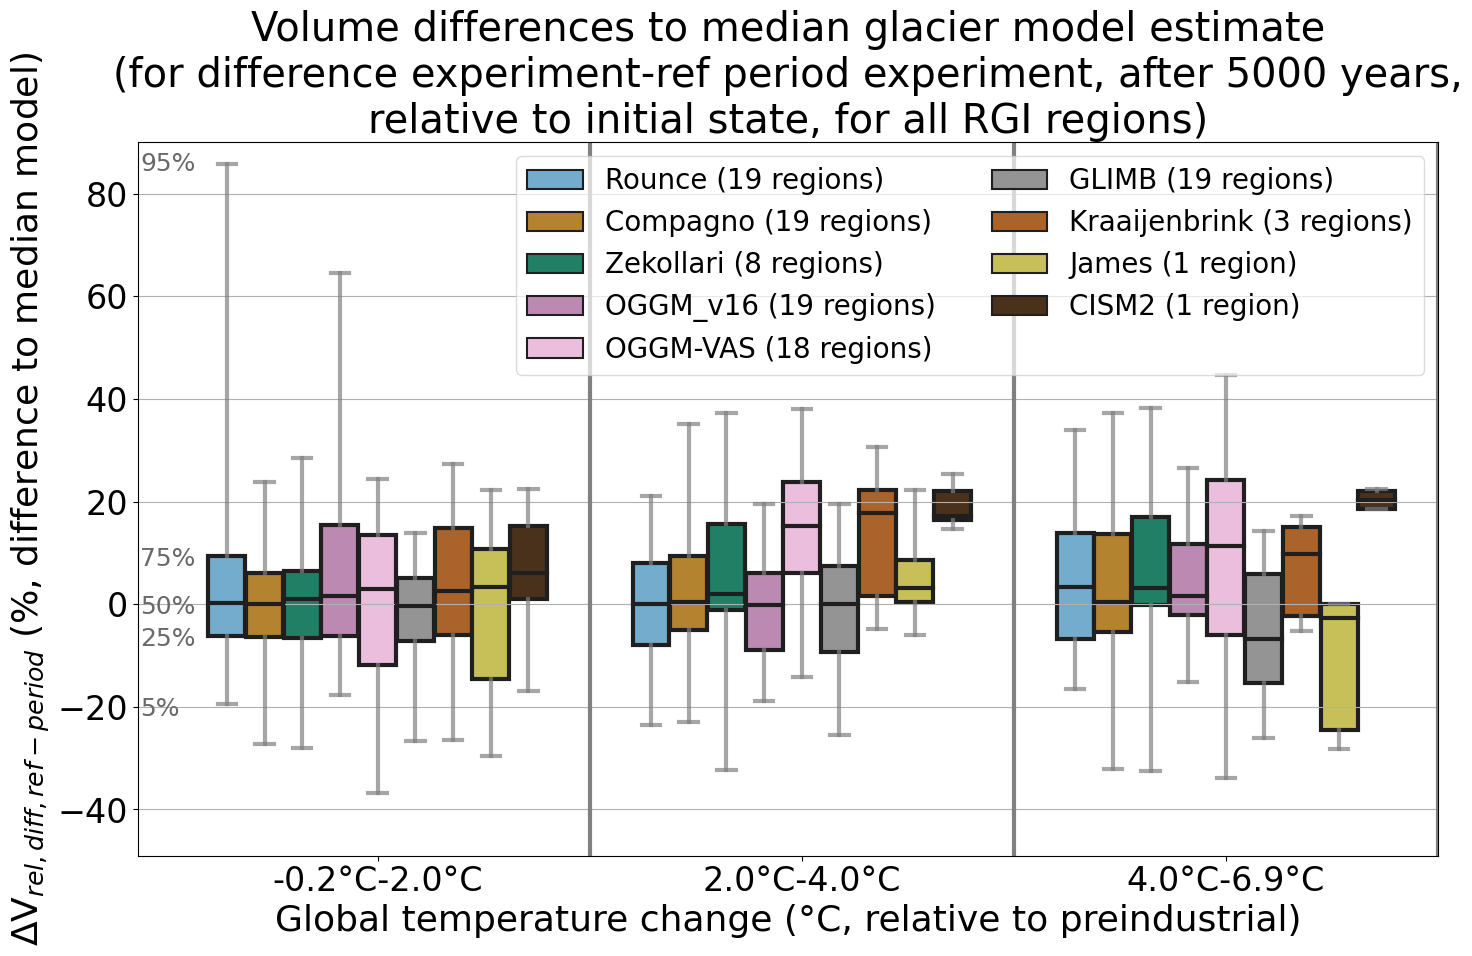

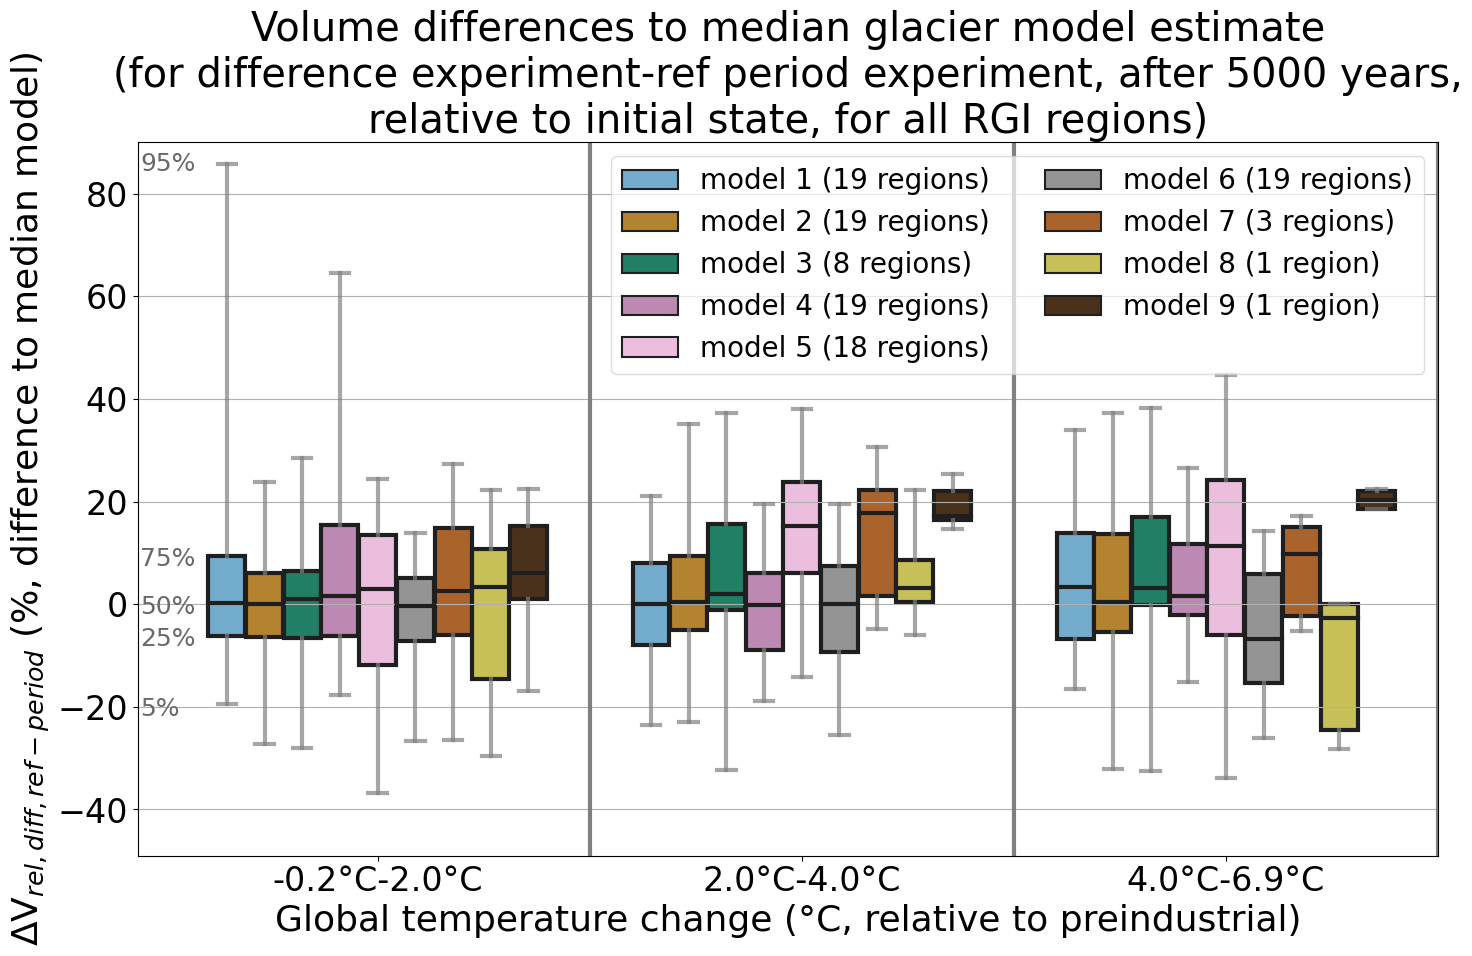

In [192]:

for anonym in ['', '_anonym']:
    plt.figure(figsize=(15,10))
    plt.rc('font', size=24)  
    sns.boxplot(data=pd_reg_models_vol_5000_no_ref_period, hue='model_author', y='delta relative volume change (in %, to median model, relative to ref period )',
                x='temp_ch_classes', palette=pal_models, saturation=0.6,
               hue_order=hue_order, dodge = True, #hue='ssp',
                                    fliersize=0, whis = [5,95], 
                                    #y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    capprops={'color':'grey', 'alpha':0.7},
                                    whiskerprops={'color':'grey', 'alpha':0.7},)
    plt.grid(axis='y')
    plt.title('Volume differences to median glacier model estimate\n(for difference experiment-ref period experiment, after 5000 years,\nrelative to initial state, for all RGI regions)')
    plt.ylabel(r'$\Delta$V$_{rel, diff,ref-period}$ (%, difference to median model)', fontsize=26)
    plt.xlabel('Global temperature change (°C, relative to preindustrial)', fontsize=26)
    for f in np.arange(0.5,3,1):
        plt.axvline(f, color= 'grey', ls='-', lw=3)

    ax = plt.gca()
    _leg = ax.get_legend()
    handles, labels = ax.get_legend_handles_labels()
    _leg.remove()
    #n = len(hue_order)
    if anonym=='_anonym':
        leg = ax.legend(handles, labels_l_anonym, #title=f'{n} models',
                        loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
    else:
        leg = ax.legend(handles, labels_l, #title=f'{n} models',
                        loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
    plt.ylim([-49, 90])
    
    qs = pd_reg_models_vol_5000_no_ref_period.groupby(['model_author', 'temp_ch_classes'])['delta relative volume change (in %, to median model, relative to ref period )'].quantile([0.05,0.25,0.5,0.75,0.95]).loc[('Rounce', '-0.2°C-2.0°C')].values
    for p,q in enumerate(qs):
        perci = [5,25,50,75,95][p]
        if perci <=75:
            ax.text(-0.56,q-2,f'{perci}%', color = 'dimgrey', fontsize=18)
        else:
            ax.text(-0.56,q*0.98,f'{perci}%', color = 'dimgrey', fontsize=18)
    xlim0,xlim1 = ax.get_xlim()
    plt.xlim([-0.565,xlim1])
    plt.tight_layout()
    plt.savefig(f'figures/3_glacier_model_diff_to_ref_period_boxplot_5000yrs{anonym}.png')

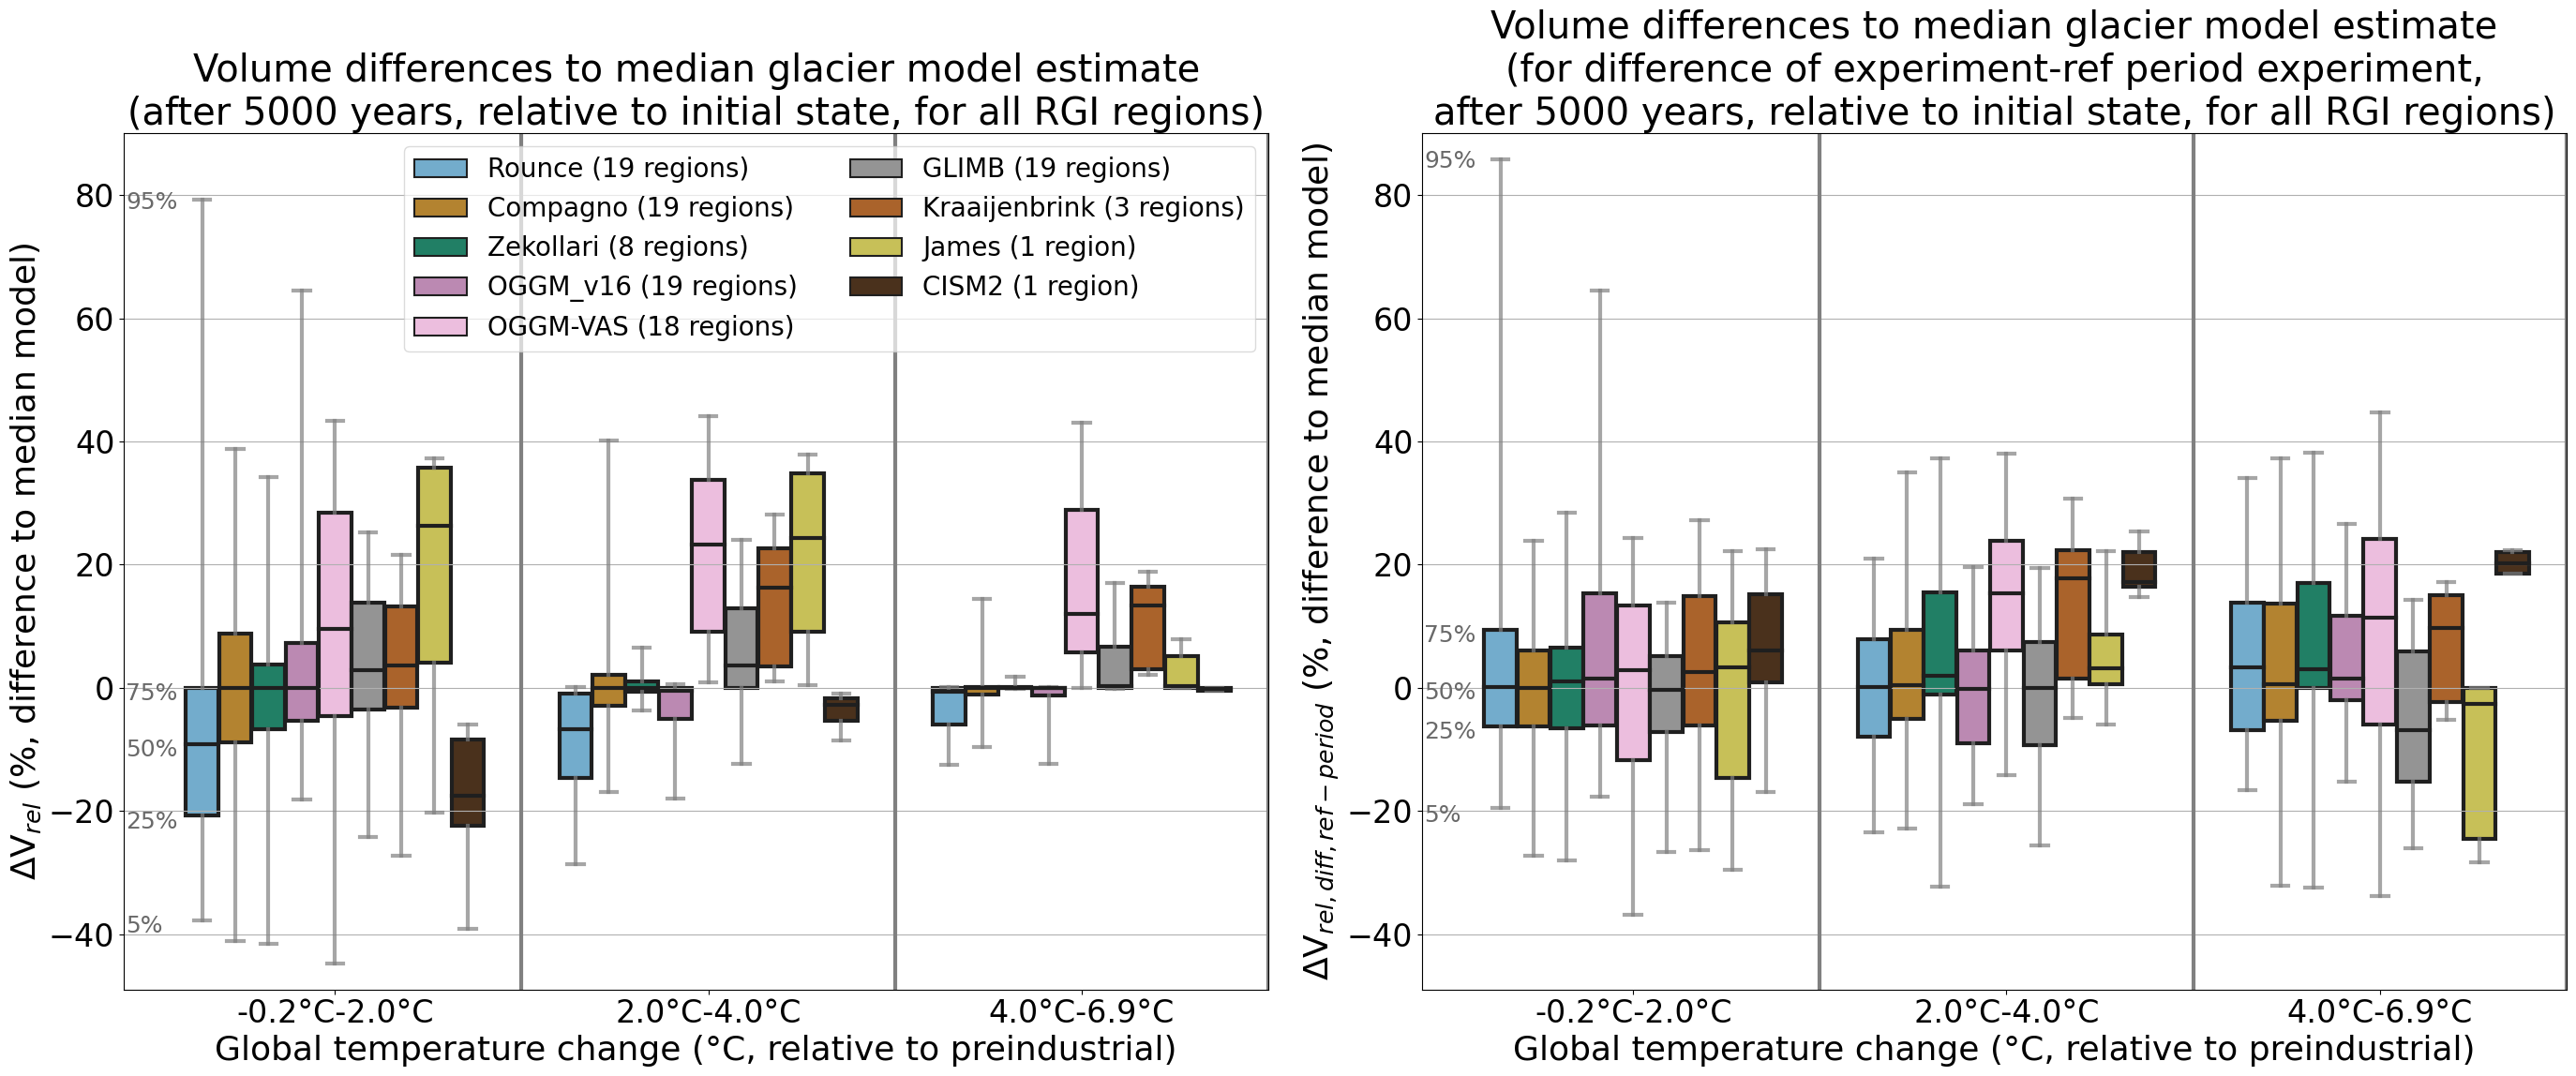

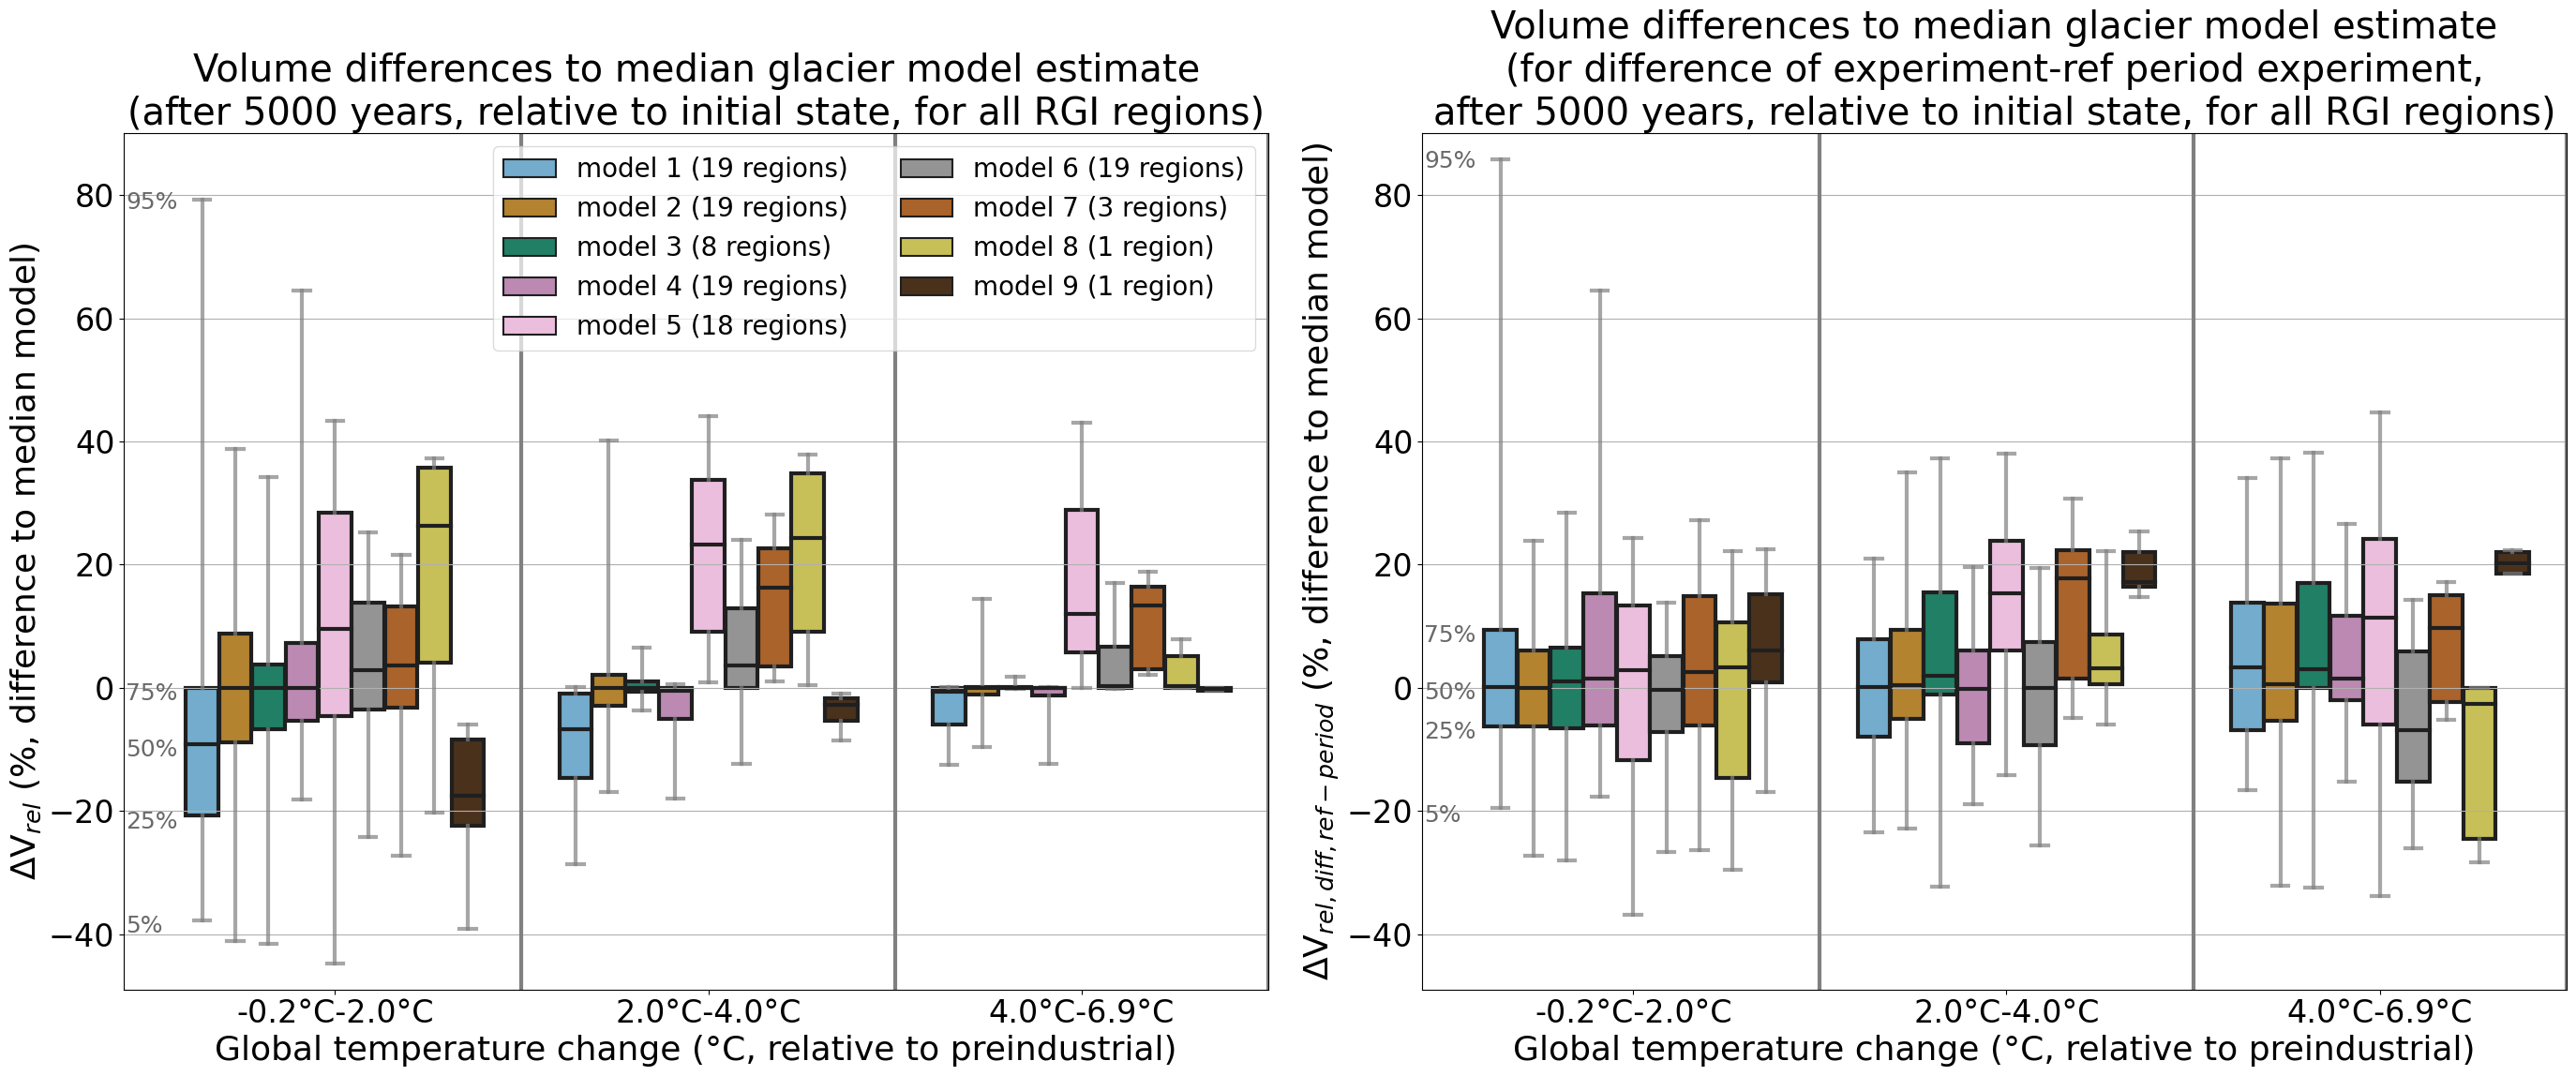

In [204]:
# both together
for anonym in ['', '_anonym']:
    fig, axs = plt.subplots(1,2,figsize=(28,12),sharey=False, sharex=True)
    plt.rc('font', size=24)  
    ##########
    ax = axs[0]
    sns.boxplot(data=pd_reg_models_vol_5000, hue='model_author', y='delta relative volume change (in %, to median model)',
                x='temp_ch_classes', palette=pal_models, saturation=0.6,
               hue_order=hue_order, dodge = True, #hue='ssp',
                                    fliersize=0, whis = [5,95], 
                                    #y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    capprops={'color':'grey', 'alpha':0.7},
                                    whiskerprops={'color':'grey', 'alpha':0.7},ax=ax)
    ax.grid(axis='y')
    ax.set_title('Volume differences to median glacier model estimate\n(after 5000 years, relative to initial state, for all RGI regions)')
    ax.set_ylabel(r'$\Delta$V$_{rel}$ (%, difference to median model)', fontsize=26)
    ax.set_xlabel('Global temperature change (°C, relative to preindustrial)', fontsize=26)
    for f in np.arange(0.5,3,1):
        ax.axvline(f, color= 'grey', ls='-', lw=3)

    _leg = ax.get_legend()
    handles, labels = ax.get_legend_handles_labels()
    _leg.remove()
    #n = len(hue_order)
    if anonym=='_anonym':
        leg = ax.legend(handles, labels_l_anonym, #title=f'{n} models',
                        loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
    else:
        leg = ax.legend(handles, labels_l, #title=f'{n} models',
                        loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
    ax.set_ylim([-49, 90])
    
    qs = pd_reg_models_vol_5000.groupby(['model_author', 'temp_ch_classes'])['delta relative volume change (in %, to median model)'].quantile([0.05,0.25,0.5,0.75,0.95]).loc[('Rounce', '-0.2°C-2.0°C')].values
    for p,q in enumerate(qs):
        perci = [5,25,50,75,95][p]
        if perci <=75:
            ax.text(-0.56,q-2,f'{perci}%', color = 'dimgrey', fontsize=18)
        else:
            ax.text(-0.56,q*0.98,f'{perci}%', color = 'dimgrey', fontsize=18)
    xlim0,xlim1 = ax.get_xlim()
    ax.set_xlim([-0.565,xlim1])
    
    
    #############
    ax = axs[1]
    sns.boxplot(data=pd_reg_models_vol_5000_no_ref_period, hue='model_author', y='delta relative volume change (in %, to median model, relative to ref period )',
                x='temp_ch_classes', palette=pal_models, saturation=0.6,
               hue_order=hue_order, dodge = True, #hue='ssp',
                                    fliersize=0, whis = [5,95], 
                                    #y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    capprops={'color':'grey', 'alpha':0.7},
                                    whiskerprops={'color':'grey', 'alpha':0.7},ax=ax)
    ax.grid(axis='y')
    ax.set_title('Volume differences to median glacier model estimate\n(for difference of experiment-ref period experiment,\nafter 5000 years, relative to initial state, for all RGI regions)')
    ax.set_ylabel(r'$\Delta$V$_{rel, diff,ref-period}$ (%, difference to median model)', fontsize=26)
    ax.set_xlabel('Global temperature change (°C, relative to preindustrial)', fontsize=26)
    for f in np.arange(0.5,3,1):
        ax.axvline(f, color= 'grey', ls='-', lw=3)

    _leg = ax.get_legend()
    handles, labels = ax.get_legend_handles_labels()
    _leg.remove()
    #n = len(hue_order)
    if anonym=='_anonym':
        leg = ax.legend(handles, labels_l_anonym, #title=f'{n} models',
                        loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
    else:
        leg = ax.legend(handles, labels_l, #title=f'{n} models',
                        loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
    leg.remove()
    ax.set_ylim([-49, 90])
    
    qs = pd_reg_models_vol_5000_no_ref_period.groupby(['model_author', 'temp_ch_classes'])['delta relative volume change (in %, to median model, relative to ref period )'].quantile([0.05,0.25,0.5,0.75,0.95]).loc[('Rounce', '-0.2°C-2.0°C')].values
    for p,q in enumerate(qs):
        perci = [5,25,50,75,95][p]
        if perci <=75:
            ax.text(-0.56,q-2,f'{perci}%', color = 'dimgrey', fontsize=18)
        else:
            ax.text(-0.56,q*0.98,f'{perci}%', color = 'dimgrey', fontsize=18)
    xlim0,xlim1 = ax.get_xlim()
    ax.set_xlim([-0.565,xlim1])
    plt.tight_layout()
    plt.savefig(f'figures/3_glacier_model_diff_and_diff_to_ref_period_boxplot_5000yrs{anonym}.png')